In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Character level N-gram Language Model
In the creation of this notebook I was heavily unfluenced by the following sources:

[1] https://github.com/karpathy/makemore

[2] https://github.com/rain1024/slp2-pdf

## Brief Introduction
Predicting in general is a difficult task. Especially trying to predict the next word, subword, character or in general a token (piece of text could be as small as a character and as big as the whole corpus). In daily life we have situations where we can predict what's coming next in a sentence...
```
Could you get some lemons from the ...?
```
Obviously, in the example above the possibilities are not infinite `["shops", "Tesco's, "Some other shop name", ...]`. How do we make that prediction in our heads? Even better question how can we come up with a system that could do those predictions for us? All those questions are related to the natural language processing (NLP) specically language models (LMs) are machine learning models that predicts the upcoming tokens.

Why do we need to predict the next token?
1. We can build systems where speech-to-text and text-to-speech could be implemented
2. We can build systems where the typos and grammatical mistakes can easily be corrected.
3. More importantly, as an inherent part of the language, predicting the next word/sentence/paragraph means the previous information has become a knowledge and accordingly the coherent communication still goes on.

In this notebook we will be starting with the simplest kind of language model: the __n-gram__ language model.


## Character Level N-gram Language Models
In this section we will both investigate the theoretical and practical implementation of the N-gram language models, which will be working in the character level meaning that our language model's goal will be to predict the __next character__ for the given sequence of text since this will be one of the easiest applications to learn the inner dynamics of language models.

The name __gram__ comes from the Greek word grámma (γράμμα), meaning _something written_ or _a small unit_. An `N`-gram represents the sequence of characters i.e. 2-gram (or _bigram_) means 2 character sequence such as $(c_1,~ c_2)$. Similarly, 3-gram (or _trigram_) means 3 character sequence such as $(c_1,~c_2,~c_3)$. The term `N`-gram means that the model is probabilistic and that can estimate the new character based on the `N-1` previous characters $(c_1,~c_2,\cdots,~c_{N-1})$.

In general sense, our task of the prediction of the next chracter prediction can be represented as $P(c~|~h)$, where $c$ and $h$ represent the next character to be predicted and the history of the characters. For instance, we can try to predict the probability of the next character being `"a"` knowing that the previous character was `"n"` $P(\text{"a"}~|~\text{"n"})$.

- One way to estimate the probability $P(\text{"a"}~|~\text{"n"})$ is directly from relative frequency counts, meaning a very large corpus, count the number of times the character `"n"` is followed by `"a"`. We can answer the question: out of times we saw the history $h$, how many times was it followed by the character $c$.

- If we had a sufficiently large corpus, we could compute this count and estimate the probability. However, as the history grows, the number of possible contexts grows exponentially and we need increasingly more data to estimate the next character accurately and coherently, which is not an easy task. Hence, we need a more clever and efficient approach.

Let's define some notation:

Throughout this notebook we will use character as tokens. To represent the probability of a particular random variable $X_i$ taking the value `"n"` represented as $P(X_i = \text{"n"}) = P(\text{"n"})$.

We will represent the sequence of $n$ characters $(c_1,~c_2,~\cdots,~c_n)$ will be represented by the notation $(c_{1:n})$. Note that the order of the elements in this notation is important.

Also, the joint probability of each chracter in a sequence having a particular value $P(X_1 = c_1,~X_2=c_2,~\cdots,~X_n=c_n)$ will be represented by $P(c_{1:n})$.

### Calculating the Probabilities of Entire Sequences
How can we compute the probabilities of the entire sequences, $(c_1,~c_2,~\cdots,~c_n)$, $P(c_1 \cap c_2 \cap \cdots \cap c_n)$? The simplest thing we can do to use the **Bayes' theorem** to recursively calculate the joint probabilities. Bayes' theorem for drawing a single card from deck example could be applied to as follows:
\begin{equation*}
P(\text{Ace} \cap \text{black}) = \frac{P(\text{drawing a black Ace})}{P(\text{drawing a black card})} = \frac{P(\text{Ace} \cap \text{black})}{P(\text{black})}
\label{eq:1} \tag{1}
\end{equation*}

<p align="left">
  <img src="images/bayes_theorem.png" alt="Bayes' theorem" width="450"/>
</p>

#### Simple/Intuitive Example
Let's simplify the task and try to understand what's going on. Let's focus on how to calculate the same probability for 3 characters? What is the probability of the characters $(c_1,~c_2,~c_3)$ occuring sequentially?
\begin{equation*}
P(\text{the sequence} ~(c_1,~c_2,~c_3)~ \text{occurring in this order}) = P(c_1\cap c_2 \cap c_3) = ~?
\label{eq:2} \tag{2}
\end{equation*}

We already know that we can use Bayes' theorem to express the joint probability of $(c_1,~c_2,~c_3)$ occuring in terms of the probability that the character $c_3$ appearing after the sequence $(c_1,~c_2)$
\begin{equation*}
P(c_3~|~ c_1 \cap c_2) = \frac{P(c_1\cap c_2\cap c_3)}{P(c_1 \cap c_2)} \quad \text{or}\quad P(c_1\cap c_2\cap c_3) = P(c_3~|~ c_1 \cap c_2)\times P(c_1 \cap c_2)
\label{eq:3} \tag{3}
\end{equation*}

Similarly, we can ask what is the probability of the character $c_2$ occuring after $c_1$?
\begin{equation*}
P(c_2~|~c_1) = \frac{P(c_2 \cap c_1)}{P(c_1)} \quad \text{or}\quad P(c_2 \cap c_1) = P(c_2~|~c_1)\times P(c_1)
\label{eq:4} \tag{4}
\end{equation*}

If we combine the expressions $\eqref{eq:2}$, $\eqref{eq:3}$ and $\eqref{eq:4}$,
\begin{equation*}
P(c_1\cap c_2 \cap c_3) = P(c_3~|~ c_1 \cap c_2)\times P(c_2~|~c_1)\times P(c_1)
\label{eq:5} \tag{5}
\end{equation*}

Let's expand the same example into a case where we would like to calculate the probability of $(c_1,~c_2,~c_3,~c_4)$ exactly in the given order:

\begin{align*}
\text{Step 1:}\quad &P(c_1\cap c_2 \cap c_3 \cap c_4) = P(c_4~|~ c_1 \cap c_2 \cap c_3)\times P(c_1 \cap c_2 \cap c_3),\\
\text{Step 2:}\quad &P(c_1 \cap c_2 \cap c_3) = P(c_3~|~ c_1 \cap c_2)\times P(c_1 \cap c_2),\\
\text{Step 3:}\quad &P(c_1 \cap c_2) = P(c_2~|~ c_1)\times P(c_1)
\end{align*}

Now, if we combine all the steps together

\begin{align*}
&P(c_1\cap c_2 \cap c_3 \cap c_4) = P(c_4~|~ c_1 \cap c_2 \cap c_3)\times P(c_3~|~ c_1 \cap c_2)\times P(c_2~|~ c_1)\times P(c_1)
\label{eq:6} \tag{6}
\end{align*}

As can be seen from above there is a nice pattern, which can be simplified as,

\begin{equation*}
P(c_1,~c_2,~\cdots,~c_n) = \prod_{k=1}^{n} P(c_k~|~ c_{1:k-1})
\label{eq:7} \tag{7}
\end{equation*}

The above expression gives us the link between the joint probabilty of a particular sequence and computing the conditional probability of the next character given previous characters.

- Please note from the above expression that the we can calculate the probability of a particular sequence occuring, $P(c_1,~c_2,~\cdots,~,c_n)$ as long as if we can calculate the conditional probability, $P(c_k~|~ c_{1:k-1})$ for each $k$. Unfortunately, we don't have any way to calculate the expression $P(c_k~|~ c_{1:k-1})$.

- As an additional note we can't just count the number of occurences of each character sequence with varying length since the number of possible combinations for a character sequence with lengh $N$ ($N$-gram) becomes $30^N$, since we will see shortly that we have $30$ characters in our Turkish names prediction alphabet, which becomes infeasible too quickly due to the highly exponential nature. Moreover, some particular sequences might have not been occured in the training corpus before!

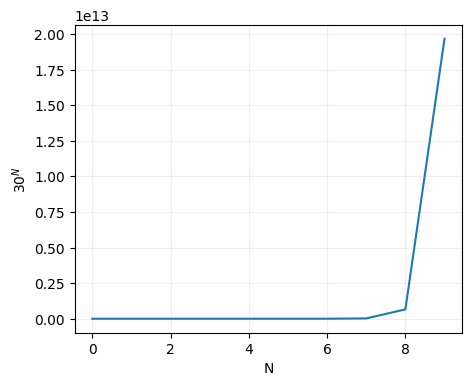

In [6]:
N = np.arange(0, 10)
fig = plt.figure(figsize=(5, 4))
plt.plot(N, 30**N)
plt.xlabel("N")
plt.ylabel("$30^{N}$")
plt.grid(True, alpha=0.2)
plt.show()

### The Markov Assumption
The intiutiton of an $N$-gram model is that instead of computing the probability of the next character being, $c$, given its entire history, $h$, we can **approximate** the history by using just a few last characters. In other words, instead of solving the following:

\begin{equation*}
P(c_1,~c_2,~\cdots,~c_n) = \prod_{k=1}^{n} P(c_k~|~ c_{1:k-1})
\label{eq:8} \tag{8}
\end{equation*}

#### Bigram Model
We can try to make the following approximation:

\begin{equation*}
P(c_1,~c_2,~\cdots,~c_n) = \prod_{k=1}^{n} P(c_k~|~ c_{k-1})
\label{eq:9} \tag{9}
\end{equation*}

In other words, we can approximate the probability $P(c_k~|~ c_{1:k-1})$, which is really hard to compute we can just use $P(c_k~|~ c_{k-1})$, where we know that we can calculate $P(c_k~|~ c_{k-1})$ much easier by just counting the bigrams ($N=2$) in the corpus.

#### Unigram Model
We can go one more notch further and assume that no history is involved in our decisions,
\begin{equation*}
P(c_1,~c_2,~\cdots,~c_n) = \prod_{k=1}^{n} P(c_k)
\label{eq:10} \tag{10}
\end{equation*}

#### Simple Example
**Markov assumption** or **Markov property** can be explained with the following example:

Assume we have a jar contains two red (2xR) and one a green (G) ball.
<p align="left">
  <img src="images/markov_assumption.png" alt="Bayes' theorem" width="250"/>
</p>

- One ball was drawn yesterday.
- One ball was drawn today.
- The final ball will be drawn tomorrow. All the draws are **without replacement**.

Suppose you know that today's ballwas **red**, but yout have no information about yesterday's ball. What can we infer about the tomorrow's ball $P(\text{drawing } R \text{ tomorrow})$?
| Today | Tomorrow     |
|-------|--------------|
|   R   | $P(R) = 0.5$ |
|   G   | $P(R) = 1$   |

If we knew what has been drawn yesterday, how would $P(\text{drawing } R \text{ tomorrow})$ change?

| Yesterday   | Today | Tomorrow    |
|-------------|-------|-------------|
| If it was R |   R   | $P(R) = 0$  |
| If it was R |   G   | $P(R) = 1$  |
| If it was G |   R   | $P(R) = 1$  |

The experiment above shows that the probability distribution for **tomorrow's color not only depends on the present value but is also information about the past**. The probability density function (pdf) is changing when we have more information about yesterdays draw. In order to understand underlying mathematics we will need to understand conditional probabilities.

##### Bayes' Theorem
Let's try to calculate the probability of drawing an ace and a card which is black:

\begin{align*}
P(\text{Ace}) &= \frac{\text{number of aces}}{\text{number of cards}} = 4/52 = 1/13 \\ \\
P(\text{Black}) &= \frac{\text{number of blacks}}{\text{number of cards}} =  13/52 = 1/4 \\ \\
P(\text{Black and Ace}) &= P(\text{Ace and Black}) = \frac{\text{number of black Aces}}{\text{number of cards}} = 1/52
\label{eq:11} \tag{11}
\end{align*}

How can we calculate the following probability? $P(\text{Ace given that we already have a black card})$? 

Since we know that we have a black card:
\begin{equation*}
P(\text{Ace given we've drawn a black card}) = P(\text{Ace}~|~\text{black}) = \frac{\text{number of black aces}}{\text{number of blacks}} = \frac{1}{13}
\label{eq:12} \tag{12}
\end{equation*}
The above expression $(\text{number of black aces})/(\text{number of blacks})$ could also be calculated using $\eqref{eq:12}$ as follows:

\begin{align*}
P(\text{Ace given we've drawn a black card}) = \frac{\text{number of black aces}}{\text{number of blacks}} = \frac{P(\text{Black and Ace})\times (\text{number of cards})}{P(\text{Black})\times(\text{number of cards})} = \frac{P(\text{Black and ace})}{P(\text{Black})}
\end{align*}
Thus,
\begin{align*}
P(\text{Ace}~|~\text{Black}) = \frac{P(\text{Black and ace})}{P(\text{Black})}
\label{eq:13} \tag{13}
\end{align*}

#### The Markov Property Continues
Since we've learnt about the conditional probabilities and Bayes' theorem. We can continue investigating the Markov property and related probabilities.
<p align="left">
  <img src="images/markov_assumption_2.png" alt="Bayes' theorem" width="350"/>
</p>
We know that if the experiment was done with replacement, the probabilities would be equal for tomorrow's draw, where today's and yesterday's draws would be irrelevant. In other words, draws would be independent and Markov property would be satisfied.
\begin{align*}
&P(G\text{ tomorrow}) = 1/3\\
&P(R\text{ tomorrow}) = 1/3 + 1/3 = 2/3
\end{align*}

However, when we have an experiment without replacement, draws are not independent and the Markov property is not getting satisfied. The above diagram summarizes the jar with three balls without replacement experiment. We can also express the probabilities using the conditional probabilities as follows:
\begin{align*}
&P(R\text{ tomorrow}~|~(R\text{ yesterday},~R\text{ today}) = 0\\
&P(R\text{ tomorrow}~|~(R\text{ yesterday},~G\text{ today})) = 1\\
&P(R\text{ tomorrow}~|~(G\text{ yesterday},~R\text{ today}) =1\\ \\
&P(R\text{ today}~|~R\text{ yesterday}) = 1/2 \\
&P(R\text{ today}~|~G\text{ yesterday}) = 1 \\ \\
&P(R\text{ tomorrow}) = 2/3 \\
&P(G\text{ tomorrow}) = 1/3
\end{align*}

#### N-gram Model

It is important to emphasize that even though the probability of some character sequence occuring is completely dependent on the whole _history_ for the simplification and approximation purposes we can assume that Markov property holds and only information we need is only $N-1$ steps in $N$-gram models. For instance, for a bigram model ($N=2$) with $n=5$ characters becomes, 
\begin{align*}
P(c_1,~c_2,~c_3,~c_4,~c_5) &= P\big(c_5~|~(c_1,~c_2,~c_3,~c_4)\big)\times P\big(c_4~|~(c_1,~c_2,~c_3)\big)\times P\big(c_3~|~(c_1,~c_2)\big)\times P(c_2~|~c_1)\times P(c_1) \\
&\approx P(c_5~|~c_4)\times P(c_4~|~c_3)\times P(c_3~|~c_2)\times P(c_2~|~c_1)\times P(c_1)
\label{eq:14} \tag{14}
\end{align*}

Let's do another example for $n=5$ and $N=3$,
\begin{align*}
P(c_1,~c_2,~c_3,c_4,~c_5) \approx P\big(c_5~|~(c_3,~c_4)\big)\times P\big(c_4~|~(c_2,~c_3)\big)\times P(c_2~|~c_1)\times P(c_1)  
\label{eq:15}\tag{15}
\end{align*}

If we generalize the expressions \eqref{eq:14} and \eqref{eq:15},
\begin{align*}
P(c_1,~c_2,c_3,~c_4,\cdots,~c_n) \approx \prod_{k=1}^{n}P(c_k~|~c_{k-N+1:k-1})
\label{eq:15} \tag{16}
\end{align*}

##### How to Estimate the Probabilities?
Now, we've obtained a simpler and more computable version of the \eqref{eq:8} in \eqref{eq:15}. However, another issue still exists. How will we calculate the probabilities $P(c_k~|~c_{k-N+1:k-1}$ or $P\big(c_k~|~(c_{k-2},~c_{k-1})\big)$ for $N=2$?

An intuitive way to estimate the probabilities is the *maximum likelihoode estimation (MLE)*. Accordingly, we can get the MLE estimates of the parameters if the $N$-gram model is the getting the counts from the corpus, and **normalizing** the counts so that they lie between $0$ and $1$. In other words, once normalized the counts could be used as the **probability distributions**.